# Implicit Recommender with ALS: The Rocket of Retail

When data is available, we can use it to build a recommender system based on the reviews left by our customers to
their favorite products. An example of this use case can be found at [this repository using the MovieLens dataset](
https://github.com/josumsc/movielens-recommender).

Nevertheless, we are often faced with the problem of building a recommender system without any explicit feedback from the
user, which is a common problem in the industry. Sometimes users are not able or willing to leave a  review, but are well
aware of their preferences. These preferences manifest by visiting the product page,  adding those products to our cart
or purchasing the product.

In this notebook, we expect to give clarity to the use of these kind of datasets based on implicit feedback to build a
recommender system that can be used to enhance the user experience.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import implicit

## Data Loading

In [2]:
df = pd.read_csv('../data/events.csv')

In [3]:
df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [37]:
df.sort_values(by='timestamp', inplace=True)

## Data Exploration

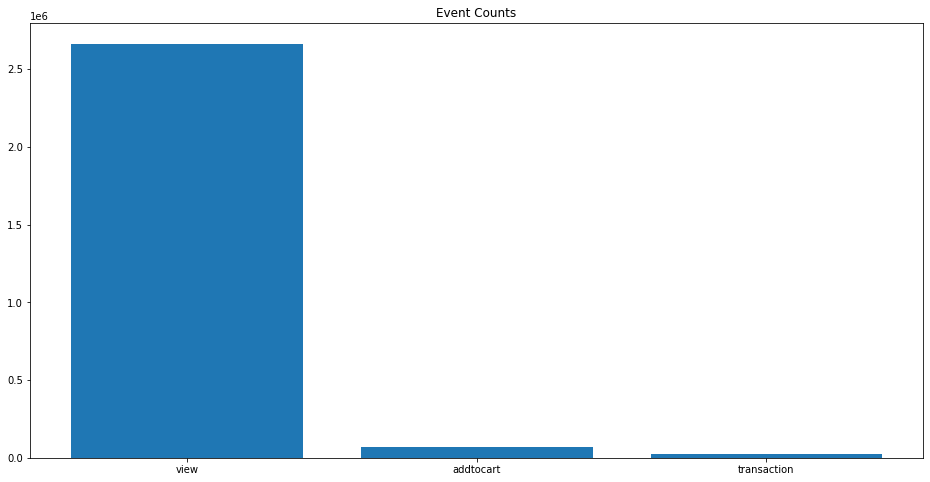

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(df['event'].value_counts().index, df['event'].value_counts().values)
ax.set_title('Event Counts')
plt.show()

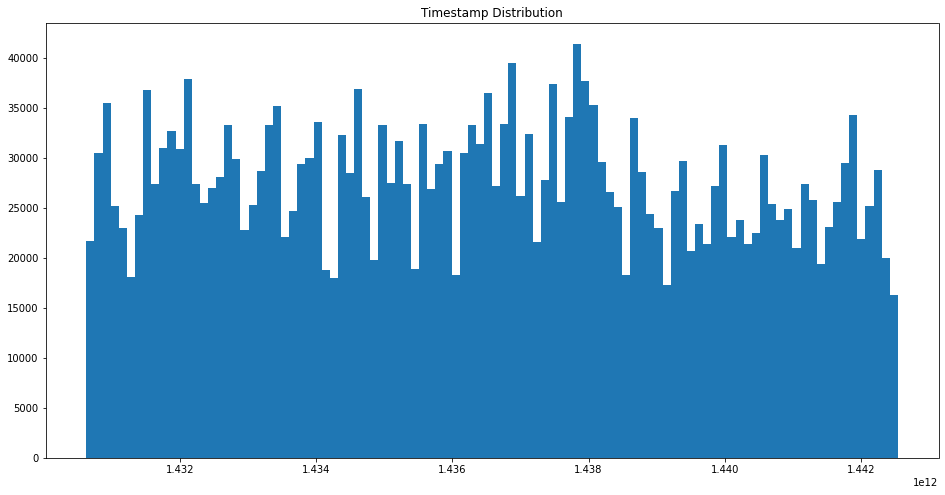

In [34]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(df['timestamp'], bins=100)
ax.set_title('Timestamp Distribution')
plt.show()

In [64]:
count_x_user_and_event = df.groupby(['visitorid', 'event']).agg({'timestamp': 'count'}).unstack()
count_x_user_and_event.fillna(0).mean().sort_values(ascending=False)

           event      
timestamp  view           1.892832
           addtocart      0.049256
           transaction    0.015954
dtype: float64

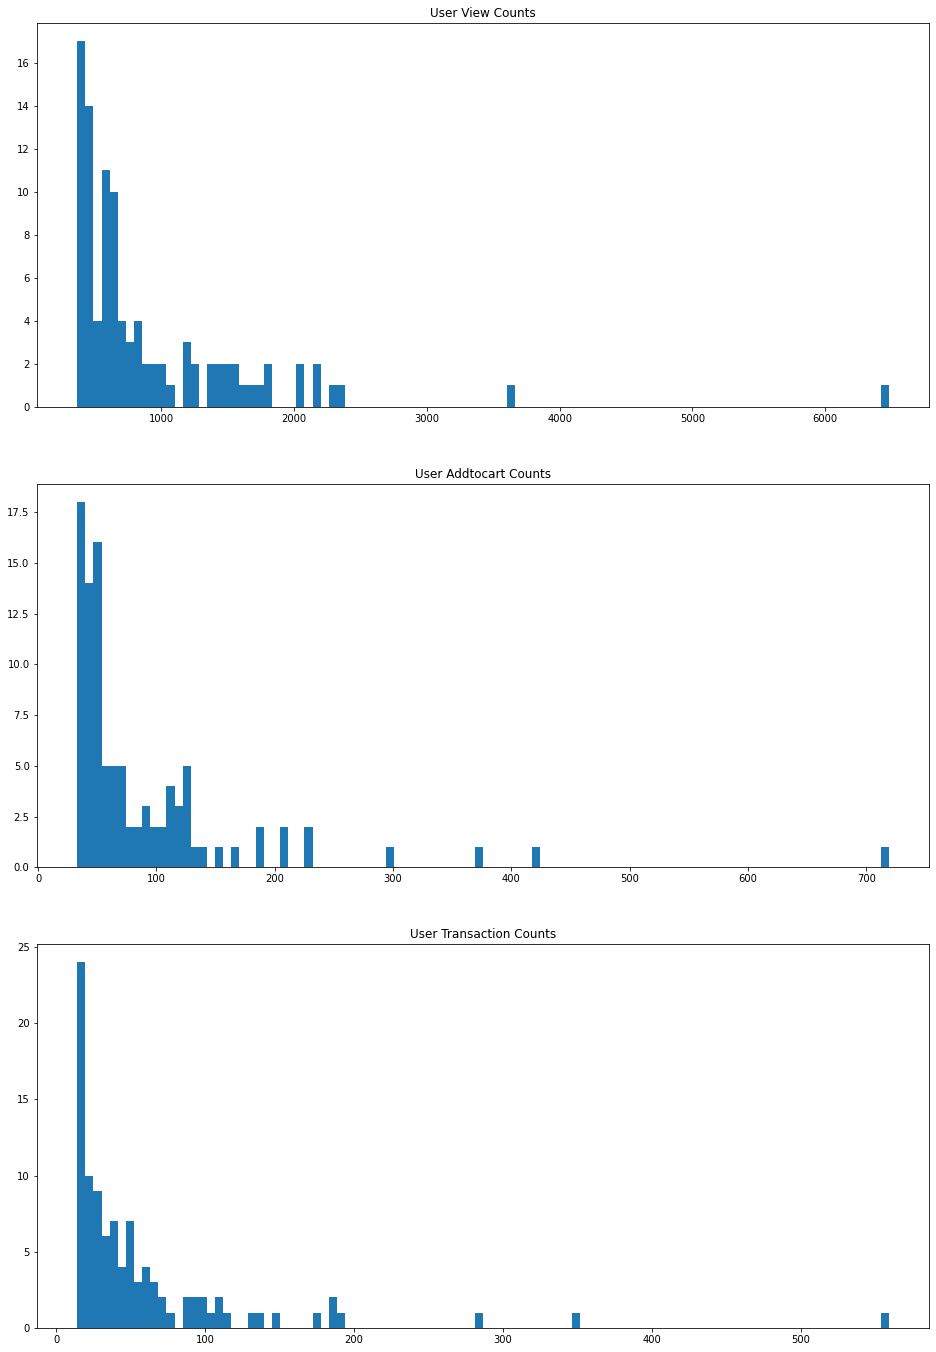

In [75]:
ax_columns = {
    0: ('timestamp','view'),
    1: ('timestamp','addtocart'),
    2: ('timestamp','transaction'),
}

fig, ax = plt.subplots(figsize=(16, 24), nrows=3)
for i, column in ax_columns.items():
    ax[i].hist(count_x_user_and_event[column].sort_values(ascending=False)[:100], bins=100)
    ax[i].set_title(f"User {column[1].capitalize()} Counts")
plt.show()

In [74]:
count_x_item_and_event = df.groupby(['itemid', 'event']).agg({'timestamp': 'count'}).unstack()
count_x_item_and_event.fillna(0).mean().sort_values(ascending=False)

           event      
timestamp  view           11.334556
           addtocart       0.294953
           transaction     0.095537
dtype: float64

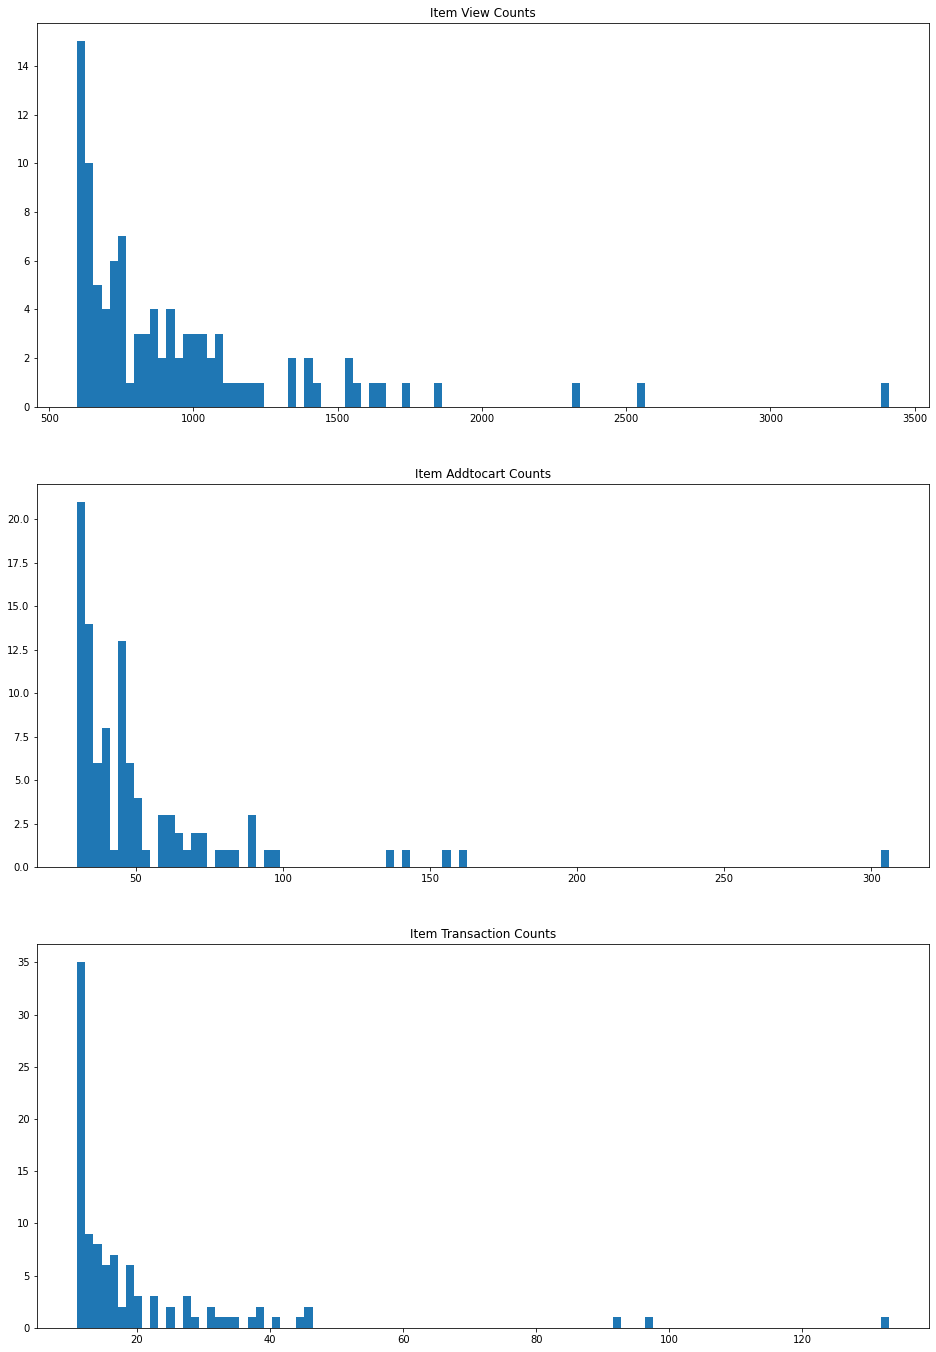

In [76]:
fig, ax = plt.subplots(figsize=(16, 24), nrows=3)
for i, column in ax_columns.items():
    ax[i].hist(count_x_item_and_event[column].sort_values(ascending=False)[:100], bins=100)
    ax[i].set_title(f"Item {column[1].capitalize()} Counts")
plt.show()

## Modelling

In [79]:
df['event_scores'] = df['event'].apply(
    lambda x: 1 if x == 'view' else 5 if x == 'addtocart' else 100 if x == 'transaction' else 0
)

In [83]:
df['visitorid'] = df['visitorid'].astype("category").cat.as_ordered()
df['itemid'] = df['itemid'].astype("category").cat.as_ordered()

In [85]:
sparse_item_user = sparse.csr_matrix((df['event_scores'].astype(float), (df['itemid'], df['visitorid'])))
sparse_user_item = sparse.csr_matrix((df['event_scores'].astype(float), (df['visitorid'], df['itemid'])))

In [87]:
latent_factors = 20
regularization = 0.1
n_iter = 20
alpha = 40

conf_matrix = (sparse_item_user * alpha).astype('double')

model = implicit.als.AlternatingLeastSquares(
    factors=latent_factors,
    regularization=regularization,
    iterations=n_iter
)

model.fit(conf_matrix)

  0%|          | 0/20 [00:00<?, ?it/s]

## Inference

In [104]:
def recommend_item_to_user(model, visitorid, sparse_item_user, n=10):
    recommended = model.recommend(visitorid, sparse_item_user[visitorid], n)
    return recommended


def similar_items_to_item(model, itemid, n=10):
    similar = model.similar_items(itemid, n)
    return similar

In [105]:
userid = 97154
recommended_items = recommend_item_to_user(model, userid, sparse_item_user)
print(f"Recommended items for user {userid}:\n{recommended_items[0]}")

Recommended items for user 97154:
[ 350566  809822  638482  895999  247235  163561 1143383 1161163 1150086
   85734]


In [106]:
itemid = 350566
similar_items = similar_items_to_item(model, itemid)
print(f"Similar items to {itemid}:\n{similar_items[0]}")

Similar items to 350566:
[ 350566   49904 1107864  490928 1403289 1157704 1358975  692163  451714
  326223]
